# The Goal here is to Learn to Separate Audio in a Efficient Way

In [3]:
#Imports
import math
import librosa
import librosa.display
import IPython.display as ipd

import pyAudioAnalysis
import pydub
import ffmpeg

import matplotlib.pyplot as plt
from numpy import sin, cos, pi, linspace, arange, log10, absolute, where
from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter, freqz, welch
from scipy.io.wavfile import read , write
from scipy.signal import spectrogram
from matplotlib import pyplot
from matplotlib.pyplot import ylabel, xlabel
from matplotlib.pyplot import plot, legend, show, grid, figure, savefig#, hold

C:\Users\Dasil\anaconda3\envs\PDS\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [157]:
Error_List = ['J_capa_01','J_cave_01','J_chata_01','J_chave_01','J_chave_02','J_farda_02','J_farta_02','N_casa_02']

filename = 'audio/training/'+'A_chata_01'+'.wav'

fs, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

#Playing Audio (Reproduce Audio)
ipd.Audio(filename)

filename:  audio/training/A_chata_01.wav
Data Length (s):  2.2
Sampling frequency (samples/s):  44100


C:\Users\Dasil\AppData\Local\Temp/ipykernel_5280/2784937275.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = read(filename)


Text(0, 0.5, 'frequency(Hz)')

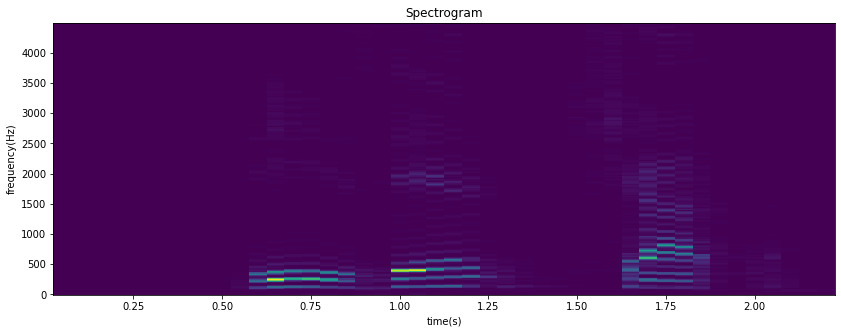

In [158]:
#Spectogram
pyplot.rcParams['figure.figsize'] = 14,5
pyplot.pcolormesh(t, f[:450], S1[:450][:])
pyplot.title("Spectrogram")
xlabel('time(s)')
ylabel('frequency(Hz)')
#show()

In [159]:
#Filtro ButterWord

wn = 1500/(fs/2)
b3,a3 = butter(4, wn)
audio1_filt = lfilter(b3,a3,audio1)

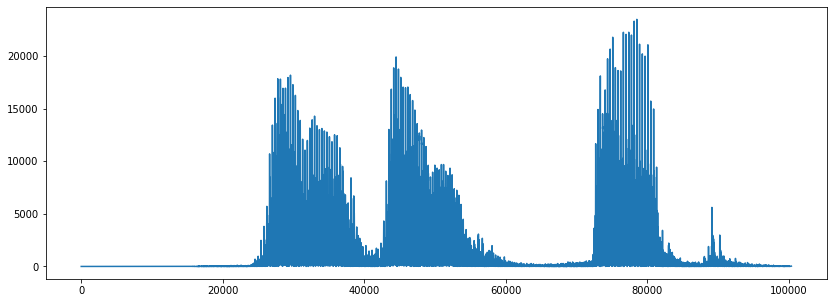

In [160]:
plot(abs(audio1_filt))

In [161]:
#results = [1 if item > 0.001*1e8 else 0 for item in audio1_filt]
results = [1 if item > 350 else 0 for item in audio1_filt]

x1: 24518
x2: 61238
x3: 68758
x4: 0


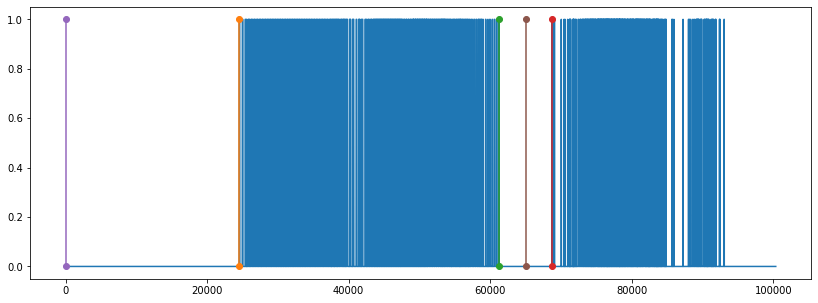

In [162]:
import numpy

x1 = 0
x2 = 0
x3 = 0
x4 = 0
flag = False
zeros_list = []
silence_len = 7500
change_len = 2000
for i, result in enumerate(results):
    if(flag == False and result == 1):
        if (x1 == 0):
            flag = True
            x1 = i
        elif (i != x1):
            flag = True
            x3 = i
    if(flag == True):
        if(result == 0):
            zeros_list.append(result)
        else:
            zeros_list = []
    if(flag == True and len(zeros_list) >= silence_len):
        if (x2 == 0):
            flag = False
            x2 = i - len(zeros_list)
            if(x2-x1 <= change_len):
                x1 = x2 = 0
        elif (i - len(zeros_list) != x2):
            flag = False
            x4 = i - len(zeros_list)
            break
            
Div_p = ((x3-x2)/2)+x2
        
print(f'x1: {x1}')
print(f'x2: {x2}')
print(f'x3: {x3}')
print(f'x4: {x4}')

plot(results)

line1 = [x1, x1], [0, 1]
line2 = [x2, x2], [0, 1]
line3 = [x3, x3], [0, 1]
line4 = [x4, x4], [0, 1]
plot(line1[0], line1[1], line2[0], line2[1], line3[0], line3[1], line4[0], line4[1], marker='o')

line5 = [Div_p, Div_p], [0, 1]
plot(line5[0],line5[1], marker='o')

#plt.savefig('pics/N_cata_02.jpeg')


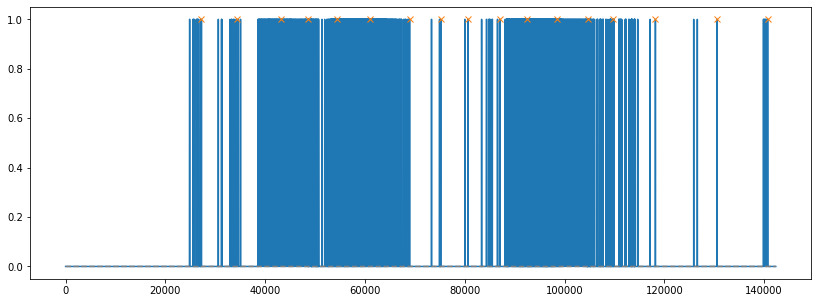

In [88]:
# to ignore
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import numpy as np

x=np.array(results)

peaks, _ = find_peaks(x, height=0, distance = 5000)
# prominence= 5)distance = 2000,

#print(peaks[0])

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [34]:
find_peaks?

# Second Possibility

In [155]:
filename = 'audio/training/J_cata_02.wav'


#List of Words
words = ["_chata_0","_chapa_0","_chave_0","_lata_0","_lapa_0","_lava_0","_casa_0","_capa_0","_cave_0","_cata_0","_chuta_0","_chupa_0","_chuva_0","_farta_0","_farpa_0","_farda_0","_ripa_0","_rita_0","_rica_0"]

#List of Dataset versions
d = {"one": 1, "two": 2}
iterable = d.keys()

#List of people
p = ['A','J','N']


In [163]:
for y in words:
    for item in iterable:      
        for x in p:
            check = x #For Validation

            #Write file path
            l = str(d[item])

            filename = 'audio/training/'+x+y+l+'.wav' #for Training DataSet
            #filename = 'audio/test/'+x+y+l+'.wav' #for Test DataSet


            #Read file path
            fs, audio1 = read(filename)
            f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

            #Apply butterworth Filter
            wn = 1500/(fs/2)
            b3,a3 = butter(4, wn)
            audio1_filt = lfilter(b3,a3,audio1)
            
            #Calculate Results
            #results = [1 if item > 0.001*1e8 else 0 for item in audio1_filt**2] (Old Attempt)
            results = [1 if item > 350 else 0 for item in audio1_filt]
            
            #Calculate limits
            x1 = 0
            x2 = 0
            x3 = 0
            x4 = 0
            flag = False
            zeros_list = []
            silence_len = 7500 #6000
            change_len = 2000
            for i, result in enumerate(results):
                if(flag == False and result == 1):
                    if (x1 == 0):
                        flag = True
                        x1 = i
                    elif (i != x1):
                        flag = True
                        x3 = i
                if(flag == True):
                    if(result == 0):
                        zeros_list.append(result)
                    else:
                        zeros_list = []
                if(flag == True and len(zeros_list) >= silence_len):
                    if (x2 == 0):
                        flag = False
                        x2 = i - len(zeros_list)
                        if(x2-x1 <= change_len):
                            x1 = x2 = 0
                    elif (i - len(zeros_list) != x2):
                        flag = False
                        x4 = i - len(zeros_list)
                        break
            
            plot(results)
            line1 = [x1, x1], [0, 1]
            line2 = [x2, x2], [0, 1]
            line3 = [x3, x3], [0, 1]
            line4 = [x4, x4], [0, 1]
            plot(line1[0], line1[1], line2[0], line2[1], line3[0], line3[1], line4[0], line4[1], marker='o')
            
            Div_p = ((x3-x2)/2)+x2
            line5 = [Div_p, Div_p], [0, 1]
            plot(line5[0],line5[1], marker='o')
            plt.savefig('pics/'+x+y+l+'.jpeg')
            plt.close()
            plt.cla()
            plt.clf()
            
            




C:\Users\Dasil\AppData\Local\Temp/ipykernel_5280/3116171527.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = read(filename)


<Figure size 1008x360 with 0 Axes>